In [1]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


In [2]:
# # specifying the zip file name
# file_name = "underwater_sem_seg.zip"
# #
# # # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')


In [3]:
# pip install torchvision

In [4]:
# os.listdir("underwater_sem_seg/dataset")

In [5]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break


['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['underwater_sem_seg/dataset/crocodile_sem_seg_gt', 'underwater_sem_seg/dataset/seal_sem_seg_gt', 'underwater_sem_seg/dataset/sea_anemone_sem_seg_gt', 'underwater_sem_seg/dataset/squid_sem_seg_gt', 'underwater_sem_seg/dataset/turtle_sem_seg_gt', 'underwater_sem_seg/dataset/sea_urchin_sem_seg_gt', 'underwater_sem_seg/dataset/penguin_sem_seg_gt', 'underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/frog_sem_seg_gt', 'underwater_sem_seg/dataset/crab_sem_seg_gt', 'underwater_sem_seg/dataset/otter_sem_seg_gt', 'und

In [6]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[245 293  46 499 480 469 252 453 286 416 525  44 233 189 424  83  45 420
 487 437 310 542  84 449 111 367 510 506 472  73 395 155 314  48 278 386
 520 536   2  59 359  20 127 348 219 158  79 515 411 103 470 478 151 231
 405 435 543 206 191 457 343 377 272 110 354  71 529 187  52  24 270 488
  41 167 267 258 141 133 232 404  81  18 440  19  33 123  80 447 356 300
 467 522 521 445 105 137 511  29 394 174 259  98 514 333  58 441 400 194
  12  32 426 207 253 212 518 313 269 374  26 482 366  65  34 285 412 202
 302 215 497 198 161 118 126 464 335 448 244 489 362 211 128 257 375  38
 166 339  57 129 217 430 535 363 172 204 273  66 379  61 186 182 477 120
 134 135 321 473 138 324 390 220 456   5 417 409 152 368 168 410 121  50
 114 164 222 357 365 139  42 351 148 403 380 459 255 271  99  51 298 358
  55 208 475  85 347 484 224 527 540 544 115  86 303 496 100   4 519 507
 180 428 264 450 329  49 112 454 122 425 494  78 296 538 446  30 254 466
 500 235 462 179 145 190 476 532 311 223 306  25 53

In [7]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform):
        self.input=input_data
        self.mask = mask
        self.transforms = transform

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms(z)
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=25
    epochs = 25
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [8]:
from torchvision import transforms
import torchvision.transforms.functional as F

transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor()])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms)
test_set = myDataset(images_test,masks_test,transforms)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

In [9]:
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = fcn_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
        self.classifier = nn.Sequential(*list(net.classifier.children())[:-1])        
#         self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#         self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
#         self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
        x = self.classifier(x)
#         x = self.last_layer(x) 
#         x = self.upsample1(x)
#         x = self.upsample2(x)
        # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(self.bn1(x)))            # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1)
        if self.training:
#             pdb.set_trace()
#             main_loss = self.criterion(x, y)
            return score

            #aux       = self.aux_classifier(x_tmp)        
            #aux_loss  = self.criterion(aux, y)
            #return x.max(1)[1], main_loss, aux_loss
            
        else:
            return score            


In [10]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyFCN(num_classes = 31)


In [11]:
lossfunc = nn.CrossEntropyLoss(ignore_index=255)
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)


In [12]:
classes = ["crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish","other"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [13]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
#     with torch.set_grad_enabled(True):
#     print("here1")
    for batch,labels in train_gen:
#             print("here2")
        batch=batch.float()
#             print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             labels = torch.nn.functional.softmax(labels,dim =1)

        predictions=model(batch)
        labels = labels.squeeze(1)
        pred_loss = lossfunc(predictions.float(),labels.long()) 
        temp_train  += pred_loss * hyperparam.bs
        
        optimizer.zero_grad()
        pred_loss.backward()
        optimizer.step()
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

In [14]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float()
            batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            labels = labels.squeeze(1)
            labels = labels.type(torch.LongTensor)
            pred_loss = lossfunc(predictions.float(),labels) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


In [ ]:
training_all_loss = []
validation_all_loss = []
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss)
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss)
    

Training avg loss =  tensor(3.6273, grad_fn=<DivBackward0>)
Test avg loss =  tensor(4.4983)
Training avg loss =  tensor(3.3366, grad_fn=<DivBackward0>)
Test avg loss =  tensor(4.1919)
Training avg loss =  tensor(3.0386, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.8263)
Training avg loss =  tensor(2.7242, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3984)
Training avg loss =  tensor(2.3834, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9449)
Training avg loss =  tensor(2.0041, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.4344)
Training avg loss =  tensor(1.6066, grad_fn=<DivBackward0>)
Test avg loss =  tensor(1.9766)
Training avg loss =  tensor(1.2200, grad_fn=<DivBackward0>)
Test avg loss =  tensor(1.4099)
Training avg loss =  tensor(0.8836, grad_fn=<DivBackward0>)
Test avg loss =  tensor(1.0098)
Training avg loss =  tensor(0.6251, grad_fn=<DivBackward0>)
Test avg loss =  tensor(0.6891)
Training avg loss =  tensor(0.4440, grad_fn=<DivBackward0>)
Test avg loss =  ten

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-de15191caf73>", line 4, in <module>
    t_avg_loss = training(model)
  File "<ipython-input-13-9a388b49d390>", line 28, in training
    optimizer.step()
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/optimizer.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/sgd.py", line 144, in step
    F.sgd(params_with_grad,
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/_functional.py", line 177, in sgd
    d_p =

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-de15191caf73>", line 4, in <module>
    t_avg_loss = training(model)
  File "<ipython-input-13-9a388b49d390>", line 28, in training
    optimizer.step()
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/optimizer.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/sgd.py", line 144, in step
    F.sgd(params_with_grad,
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/_functional.py", line 177, in sgd
    d_p =

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-de15191caf73>", line 4, in <module>
    t_avg_loss = training(model)
  File "<ipython-input-13-9a388b49d390>", line 28, in training
    optimizer.step()
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/optimizer.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/sgd.py", line 144, in step
    F.sgd(params_with_grad,
  File "/N/u/sparanjp/Carbonate/.conda/envs/AML/lib/python3.8/site-packages/torch/optim/_functional.py", line 177, in sgd
    d_p =

ERROR! Session/line number was not unique in database. History logging moved to new session 56


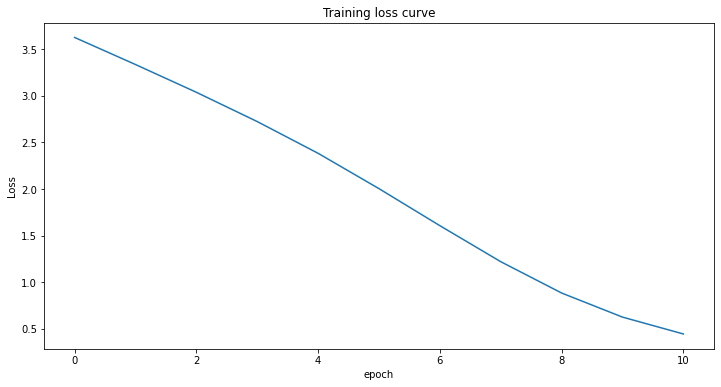

In [15]:
import matplotlib.pyplot as plt
training_total_loss = [ i.detach().numpy() for i in training_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(training_total_loss)),training_total_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Training loss curve')
plt.show()


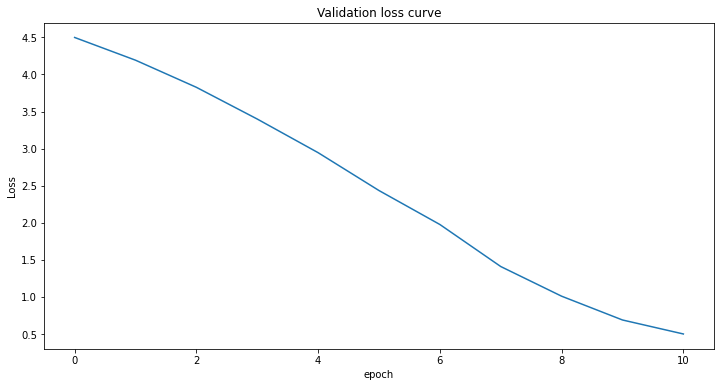

In [19]:
import matplotlib.pyplot as plt
# validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Validation loss curve')
plt.show()

In [21]:
import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in train_gen:
#             print("here2")
        batch=batch.float()
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
        print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
        npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1)
        print("np ", npred.size())
        labels = labels.squeeze(1)
        labels = labels.type(torch.LongTensor)
#             print("label size", labels.size())
        pred_loss = lossfunc(npred,labels) 
#         testing_loss.append(pred_loss)
        print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break


here
here1
batch size torch.Size([25, 3, 256, 256])
np  torch.Size([25, 31, 256, 256])
pred_loss tensor(2.7377)


In [26]:

import matplotlib.pyplot as plt
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img2 = (img>0.5).float()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# i = 0        
# for mask in masks:
# #     print(i)
#     show(mask)
#     i=i+1
show(masks[0:30])

In [ ]:
# from PIL import Image
# import torchvision.transforms as T
# transform = T.ToPILImage(mode = np.dtype(float))
# img = npred
# # img = torch.argmax(npred.squeeze(),dim=1)
# print(img.size())
# print(img[0].max())
# image = transform(img[0])
# new_im = ((npred - npred.min()) * (1/(npred.max() - npred.min()) * 255))
# new_im.max()
# image = transform(new_im)

In [ ]:
# image

In [ ]:
# transform = T.ToPILImage()
# image = transform(batch[1])
# image